In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
from scipy import stats
%matplotlib inline

In [2]:
xr.__version__

'0.15.1'

In [3]:
#for use on Casper
ncores = 12
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='2:30:00')
cluster.scale(ncores)
client = Client(cluster)

In [4]:
# note that the extra workers can get stuck in the queue
client

Client Scheduler: tcp://10.12.205.30:37641 Dashboard: http://10.12.205.30:41727/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some useful functions

In [8]:
def get_monthly(data_vars,firstyear=1850):
    """ retrieve monthly data from LENS2 using xarray

    Keyword arguments:
    data_vars -- list of required variables
    firstyear -- first year required for analysis
    
    Notes:
      * you don't need to ask for lat,lon,etc
      * the data are chunked by decade, so:
          firstyear =1995 yields [1990,2014]
      * you must be on casper for this to work (not cheyenne)
      * each 1d variable is 1.3GB/decade, consider taking only what you need :)
    """
    
    # find the ensemble directories
    topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
    mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
    lnd    = '/lnd/proc/tseries/month_1/'
    # establish an ensemble dimension
    ensdim  = xr.DataArray(np.arange(len(mlist)), dims='ens', name='ens')
    ensdim.attrs['long_name']='ensemble number'
    # set up the year strings in each file
    yy1 = max(1850,10*int(firstyear/10))
    years = np.arange(yy1,2011,10)
    year_strs = []
    for year in years:
        if year<2001:
            yy = str(year)+'01-'+str(year+9)+'12'
        else:
            yy = '201001-201412'
        year_strs.append(yy)
        
    #read in the data
    firstvar = True
    for field in data_vars:
        dsets=[]
        for yy,year in zip(year_strs,years):
            paths = [glob.glob(mm+lnd+'*.h0.'+field+'.'+yy+'*')[0] for mm in mlist]
            ds_temp = xr.open_mfdataset(paths,combine='nested',decode_times=False,
                                        concat_dim=ensdim,parallel=True)[field]
            nmonths = len(ds_temp['time'])
            time_vec   = xr.cftime_range(str(year),periods=nmonths,freq='MS')
            ds_temp['time'] = time_vec
            dsets.append(ds_temp)

            if firstvar:    #need to instantiate ds
                firstvar = False
                mm = mlist[0]
                paths = [glob.glob(mm+lnd+'*.h0.'+field+'.'+yy+'*')[0] for yy in year_strs]
                ds = xr.open_mfdataset(paths,combine='by_coords')
                nmonths = len(ds['time'])
                time_vec   = xr.cftime_range(str(year),periods=nmonths,freq='MS')
                ds['time'] = time_vec

        ds[field] =xr.concat(dsets,dim='time')
    return ds

In [2]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [9]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

### Here I actually read the data in

In [11]:
%%time
data_vars = ['NBP','TWS']
firstyear = 2000
ds = get_monthly(data_vars,firstyear)

CPU times: user 5.33 s, sys: 1.27 s, total: 6.6 s
Wall time: 7.03 s


## Sample analyses

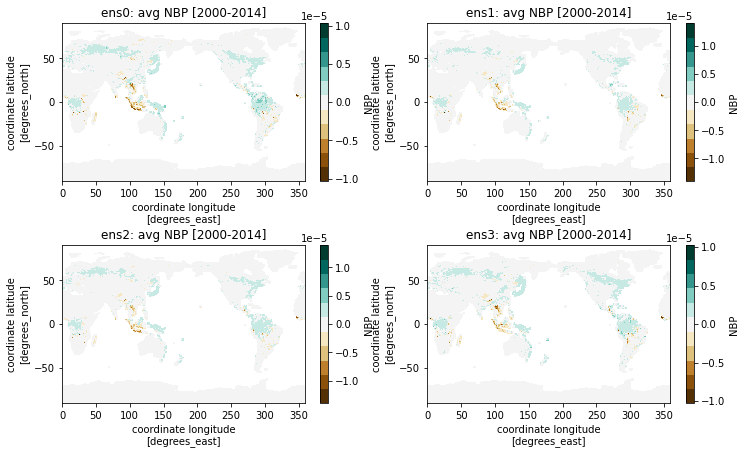

In [18]:
plt.figure(figsize=[12,7])
for ee in range(4):
    plt.subplot(2,2,ee+1)
    ds.NBP.sel(ens=ee).mean(dim='time').plot(cmap=ccc)
    plt.title('ens'+str(ee)+': avg NBP [2000-2014]');
plt.subplots_adjust(hspace=0.4)

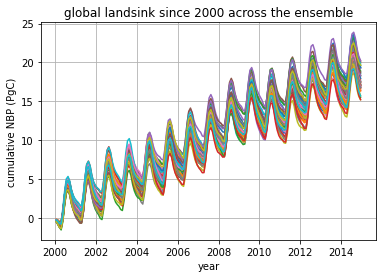

In [19]:
landarea = ds['area']*ds['landfrac']
nyears   = len(np.unique(ds['time.year']))
xf       = 24*60*60*1e-9

monthly_nbp = xf*month_wts(nyears)*(landarea*ds.NBP).sum(dim=['lat','lon']) #PgC
cumsum      = monthly_nbp.cumsum(dim='time').values

t = firstyear+(np.cumsum(month_wts(nyears))-15)/365
plt.plot(t,cumsum)
plt.grid()
plt.ylabel('cumulative NBP (PgC)');
plt.xlabel('year')
plt.title('global landsink since 2000 across the ensemble');